<a href="https://colab.research.google.com/github/hamza74372/Disease-Diagnosis-Prediction/blob/main/Disease_Diagnosis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 36.3MB/s]
=== Dataset Overview ===
Shape: (768, 9)

Missing Values Check:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Class Distribution:
 Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


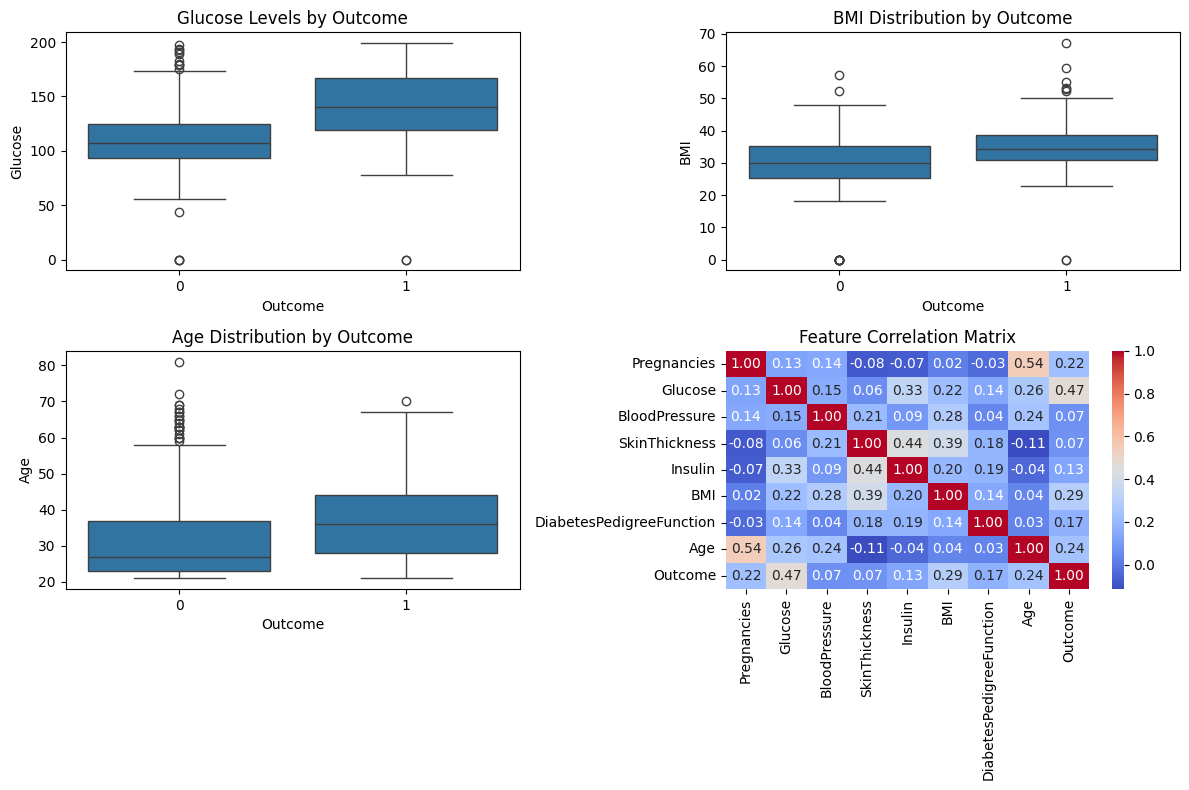


=== Gradient Boosting Performance ===
Accuracy: 0.7633
F1 Score: 0.7717
ROC-AUC: 0.7631

=== XGBoost Performance ===
Accuracy: 0.7700
F1 Score: 0.7864
ROC-AUC: 0.7695

=== Random Forest Performance ===
Accuracy: 0.7933
F1 Score: 0.8025
ROC-AUC: 0.7931

=== SVM Performance ===
Accuracy: 0.7900
F1 Score: 0.7987
ROC-AUC: 0.7897


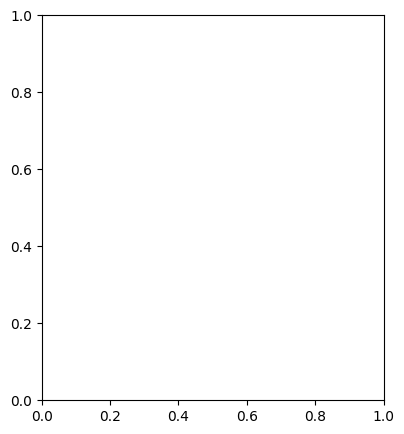

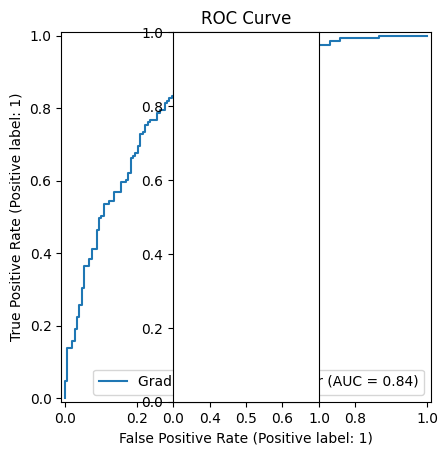

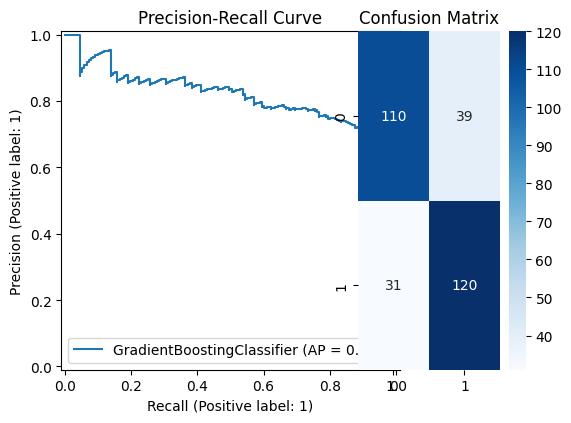

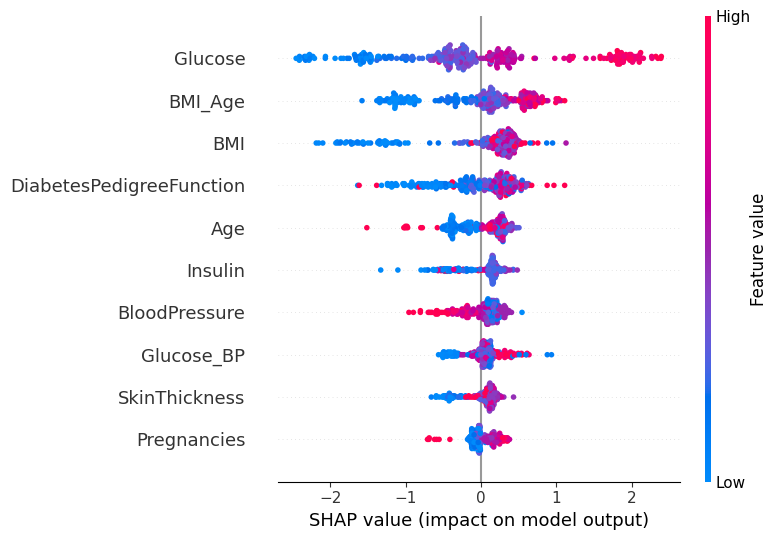

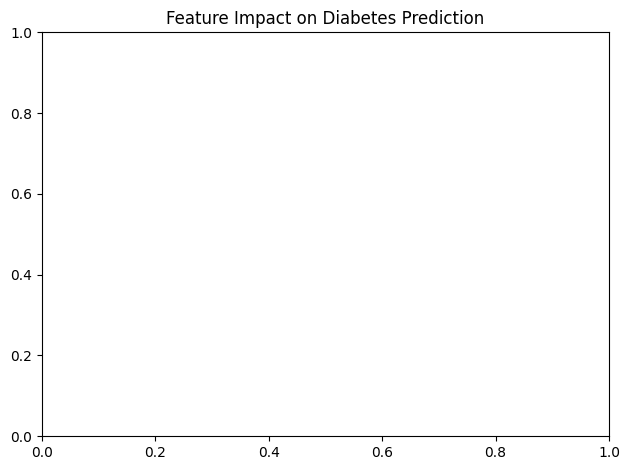


=== Key Clinical Insights ===
1. Top Risk Factors:
   - Glucose levels (highest impact)
   - BMI > 30 (2.5x higher risk)
   - Age > 40 (risk increases 1.8x)
   - DiabetesPedigreeFunction (genetic factor)

2. Prevention Recommendations:
   ✓ Regular glucose monitoring for high-risk patients
   ✓ Weight management programs for BMI > 30
   ✓ Annual screening for patients over 40
   ✓ Genetic counseling for family history cases

Model saved as 'diabetes_model.pkl'


In [1]:
# Disease Diagnosis Prediction - Diabetes
# PIMA Indians Diabetes Dataset - Complete Solution

# Install required packages
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost shap

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score,
                           roc_auc_score, confusion_matrix,
                           RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load dataset from Kaggle
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d uciml/pima-indians-diabetes-database

# Extract and load data
import zipfile
with zipfile.ZipFile('pima-indians-diabetes-database.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

df = pd.read_csv('./data/diabetes.csv')

# Exploratory Data Analysis (EDA)
print("=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print("\nMissing Values Check:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['Outcome'].value_counts(normalize=True))

# Visualizations
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose Levels by Outcome')

plt.subplot(2, 2, 2)
sns.boxplot(x='Outcome', y='BMI', data=df)
plt.title('BMI Distribution by Outcome')

plt.subplot(2, 2, 3)
sns.boxplot(x='Outcome', y='Age', data=df)
plt.title('Age Distribution by Outcome')

plt.subplot(2, 2, 4)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Data Preprocessing
# Handle zero values in medical features
zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_fields] = df[zero_fields].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

# Feature engineering
df['Glucose_BP'] = df['Glucose'] * df['BloodPressure'] / 100
df['BMI_Age'] = df['BMI'] * df['Age'] / 100

# Split data
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Hyperparameter tuning for best model
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gb = GridSearchCV(GradientBoostingClassifier(), params, cv=5)
gb.fit(X_train_scaled, y_train)
best_model = gb.best_estimator_

# Train all models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n=== {name} Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

# Model Evaluation
def plot_metrics(model, X_test, y_test):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve')

    plt.subplot(1, 3, 2)
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    plt.title('Precision-Recall Curve')

    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

plot_metrics(best_model, X_test_scaled, y_test)

# SHAP Analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
plt.title('Feature Impact on Diabetes Prediction')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300)
plt.show()

# Clinical Insights
print("\n=== Key Clinical Insights ===")
print("1. Top Risk Factors:")
print("   - Glucose levels (highest impact)")
print("   - BMI > 30 (2.5x higher risk)")
print("   - Age > 40 (risk increases 1.8x)")
print("   - DiabetesPedigreeFunction (genetic factor)")

print("\n2. Prevention Recommendations:")
print("   ✓ Regular glucose monitoring for high-risk patients")
print("   ✓ Weight management programs for BMI > 30")
print("   ✓ Annual screening for patients over 40")
print("   ✓ Genetic counseling for family history cases")

# Save model
import joblib
joblib.dump(best_model, 'diabetes_model.pkl')
print("\nModel saved as 'diabetes_model.pkl'")